# This notebook contains the code to explore the effectiveness of the coefficient selection algorithm across different steering vectors.
It generates all the graphs in the results section.
You will need to enter a Huggingface API key with access to the Llama 3 models.

Note that this is highly unoptimized, and is set up to run on 2x 80gb GPUs (I used 2x A100s).

In [1]:
# Notebook / Runpod setup, safe to ignore
%pip install python-dotenv anthropic matplotlib accelerate datasets einops huggingface-hub jaxtyping natsort simple-parsing triton transformers gguf sentencepiece scikit-learn seaborn umap-learn
%pip install -U safetensors
%pip install git+https://github.com/EleutherAI/sae.git


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/EleutherAI/sae.git to /tmp/pip-req-build-0xg4ferg
  Running command git clone --filter=blob:none --quiet https://github.com/EleutherAI/sae.git /tmp/pip-req-build-0xg4ferg
  Resolved https://github.com/EleutherAI/sae.git to commit 0b58af41d3da3dcd8df31839612c6dc91c310459
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
from dotenv import load_dotenv
import sys, os

notebook_dir = os.path.abspath('')  # Get current notebook directory
experiments_dir = os.path.dirname(notebook_dir)  # Get parent directory
sys.path.insert(0, experiments_dir)
os.environ["HF_HOME"] = os.path.join(experiments_dir, "hf")

# Load environment variables from .env file
load_dotenv()

True

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
import json

import tqdm
import torch
import numpy as np

from repeng import ControlVector, ControlModel, DatasetEntry
import repeng.saes

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter
import math

import anthropic
import json
import pickle

from typing import Union, List, Dict
from anthropic.types.beta.message_create_params import MessageCreateParamsNonStreaming
from anthropic.types.beta.messages.batch_create_params import Request

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import gc
torch.cuda.empty_cache()

# Collect garbage
gc.collect()

# Force CUDA to sync
torch.cuda.synchronize()

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")
tokenizer.pad_token_id = tokenizer.eos_token_id

control_layers = list(range(1, 31))

In [7]:
base_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B",
    torch_dtype="auto").to(
    torch.device("cuda:0"))
base_model = ControlModel(base_model, control_layers)

instruct_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    torch_dtype="auto").to(
    torch.device("cuda:0"))
instruct_model = ControlModel(instruct_model, control_layers)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
#sae_labeled = repeng.saes.from_eleuther(device="cuda:0", layers=[24, 30], repo='EleutherAI/sae-llama-3.1-8b-64x', revision='cca69a815bf3e8ce60f3ed19d197cd6e4e3662cc')
sae_full = repeng.saes.from_eleuther(device="cuda:1", layers=control_layers)

Fetching 66 files:   0%|          | 0/66 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


In [9]:
# repeng dataloading / template boilerplate
with open(os.path.join(notebook_dir, "data/all_truncated_outputs.json")) as f:
    output_suffixes = json.load(f)
truncated_output_suffixes = [
    tokenizer.convert_tokens_to_string(tokens[:i])
    for tokens in (tokenizer.tokenize(s) for s in output_suffixes)
    for i in range(1, len(tokens))
]
truncated_output_suffixes_512 = [
    tokenizer.convert_tokens_to_string(tokens[:i])
    for tokens in (tokenizer.tokenize(s) for s in output_suffixes[:512])
    for i in range(1, len(tokens))
]

# base model so roll our own instruct template
# TEMPLATE = """{persona} is talking to the user.

# User: {user_msg}

# AI: {prefill}"""
# TEMPLATE = """<|start_header_id|>system<|end_header_id|>
# {persona} is talking to the user.<|eot_id|><|start_header_id|>user<|end_header_id|>

# {user_msg}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

# {prefill}"""
TEMPLATE = """{persona}. {prefill}"""

def template_parse(resp: str) -> tuple[str, str, str]:
    if "<|start_header_id|>user" in resp:
        persona = ""
        _, rest = resp.split("<|start_header_id|>user<|end_header_id|>")
        user, assistant = rest.split("<|eot_id|><|start_header_id|>assistant<|end_header_id|>")
    elif "User:" in resp:
        persona, rest = resp.split("\n\nUser: ", 1)
        user, assistant = rest.split("\n\nAI: ", 1)
    else:
        persona = ""
        user = ""
        assistant = resp

    return (persona.strip(), user.strip(), assistant.strip())

def make_dataset(
    persona_template: str,
    positive_personas: list[str],
    negative_personas: list[str],
    user_msg: str,
    suffix_list: list[str]
) -> list[DatasetEntry]:
    dataset = []
    for suffix in suffix_list:
        for positive_persona, negative_persona in zip(positive_personas, negative_personas):
            pos = persona_template.format(persona=positive_persona)
            neg = persona_template.format(persona=negative_persona)
            dataset.append(
                DatasetEntry(
                    positive=TEMPLATE.format(persona=pos, user_msg=user_msg, prefill=suffix),
                    negative=TEMPLATE.format(persona=neg, user_msg=user_msg, prefill=suffix),
                )
            )
    return dataset

from IPython.display import display, HTML
from transformers import TextStreamer

class HTMLStreamer(TextStreamer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.display_handle = display(display_id=True)
        self.full_text = ""

    def _is_chinese_char(self, _):
        # hack to force token-by-token streaming
        return True

    def on_finalized_text(self, text: str, stream_end: bool = False):
        self.full_text += text
        persona, user, assistant = template_parse(self.full_text)
        html = HTML(f"""
        <div style='border: 1px solid black; border-radius: 5px; margin-bottom: 5px; padding: 5px;'>
            <strong>persona</strong>
            <p>{persona}</p>
            <strong>user</strong>
            <p>{user}</p>
            <strong>assistant</strong>
            <p>{assistant}</p>
        </div>
        """)
        self.display_handle.update(html)

def generate_with_vector(
    model,
    input: str,
    labeled_vectors: list[tuple[str, ControlVector]],
    max_new_tokens: int = 128,
    repetition_penalty: float = 1.1,
    show_baseline: bool = False,
    temperature: float = 0.7,
):
    input_ids = tokenizer(input, return_tensors="pt").to(model.device)
    settings = {
        "pad_token_id": tokenizer.eos_token_id, # silence warning
        #"do_sample": False, # temperature=0
        "temperature": temperature,
        "max_new_tokens": max_new_tokens,
        "repetition_penalty": repetition_penalty,
    }

    def gen(label):
        display(HTML(f"<h3>{label}</h3>"))
        output = model.generate(streamer=HTMLStreamer(tokenizer), **input_ids, **settings)
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        # perplexity = calculate_perplexity(model, tokenizer, generated_text)
        # display(HTML(f"<p>Perplexity: {perplexity:.2f}</p>"))
        print(generated_text)

    if show_baseline:
        model.reset()
        gen("baseline")
    for label, vector in labeled_vectors:
        model.set_control(vector)
        gen(label)
    model.reset()

In [10]:
def visualize_discontinuities(x, y, discontinuities):
    """
    Visualize the detected discontinuities on the original data.
    """
    plt.figure(figsize=(12, 6))
    # Change from line plot to scatter plot
    plt.scatter(x, y, c='b', s=20, alpha=0.6, label='Original data')
    
    x_discontinuities = x[discontinuities]
    y_discontinuities = y[discontinuities]

    plt.scatter(x_discontinuities, y_discontinuities, c='r', s=100, 
               label='Detected discontinuities', zorder=3)
    
    # Add vertical lines at discontinuities
    for idx in discontinuities:
        plt.axvline(x=x[idx], color='r', linestyle='--', alpha=0.3)
    
    plt.legend()
    plt.grid(True)
    plt.title('Detected Discontinuities')
    plt.show()

def find_significant_drop(x, y, drop_threshold=0.10, window_size=1):
    """
    Find the first point where perplexity drops significantly below starting value.
    
    Parameters:
    x: array-like, coefficients
    y: array-like, perplexity values
    drop_threshold: float, minimum drop as fraction of starting value (default 0.2 = 20%)
    window_size: int, number of consecutive points to check to avoid noise (default 3)
    
    Returns:
    tuple: (x value where drop occurs, index of drop point)
    """
    # Get baseline from start of sequence
    baseline = y[0]
    target_value = baseline * (1 + drop_threshold)
    
    # Look for first window where all values are below target
    for i in range(len(y) - window_size + 1):
        window = y[i:i+window_size]
        if all([val < target_value for val in window]):
            return i
            
    # If no significant drop found
    return None

def calculate_entropy(model, sequence):
    tokens = sequence.tolist()
    token_counts = Counter(tokens)
    total_tokens = len(tokens)
    probabilities = [count / total_tokens for count in token_counts.values()]
    entropy = -sum(p * math.log2(p) for p in probabilities if p > 0)
    max_entropy = math.log2(len(token_counts))
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    return normalized_entropy

def calculate_perplexity_with_entropy(model, sequence, beta=10):
    perplexity = calculate_perplexity(model, sequence)
    norm_entropy = calculate_entropy(model, sequence)
    adjusted_perplexity = perplexity * (1 + beta * ((1 - norm_entropy)**2))
    return adjusted_perplexity

def calculate_repetition_score(model, sequence):
    """
    Calculate a repetition score based on repeated token sequences.
    Returns a value between 0 and 1, where higher values indicate more repetition.
    """
    tokens = sequence.tolist()
    if len(tokens) <= 1:
        return 0
    
    # Look for repeating sequences of 2-4 tokens
    ngram_scores = []
    for n in range(2, 5):
        if len(tokens) > n:
            # Create n-grams
            ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
            # Count repetitions
            ngram_counts = Counter(ngrams)
            # Calculate score for this n-gram size
            score = sum(c - 1 for c in ngram_counts.values()) / max(len(ngrams), 1)
            ngram_scores.append(score)
    
    # Weight longer sequences more heavily
    if ngram_scores:
        weights = [1, 2, 3]  # More weight to longer sequences
        repetition_score = sum(s * w for s, w in zip(ngram_scores, weights)) / sum(weights)
        return min(repetition_score, 1.0)
    return 0.0

def calculate_perplexity_with_repetition_bias(model, sequence, beta=10):
    """
    Adjust perplexity based on repetition in the token sequence.
    Higher repetition leads to higher adjusted perplexity.
    """
    perplexity = calculate_perplexity(model, sequence)
    repetition_score = calculate_repetition_score(model, sequence)
    adjusted_perplexity = perplexity * (1 + beta * (repetition_score**2))
    return adjusted_perplexity

def calculate_perplexity(model, sequence):
    input_ids = sequence.unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        perplexity = torch.exp(loss).item()
    return perplexity

def cross_entropy_loss(model, sequence):
    input_ids = sequence.unsqueeze(0)
    
    # Create targets by shifting input_ids right
    targets = input_ids.clone()[:, 1:]  # Remove first token
    inputs = input_ids[:, :-1]  # Remove last token
    
    with torch.no_grad():
        outputs = model(inputs)
        logits = outputs.logits
        
    # Use CrossEntropyLoss
    loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')  # or 'sum' if you want total loss
    loss = loss_fn(logits.view(-1, logits.size(-1)), targets.view(-1))
    
    return loss.item()

def sequence_probability(model, sequence):
    input_ids = sequence.unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits
        
    log_probs = F.log_softmax(logits, dim=-1)
    
    # Process tokens in chunks to avoid numerical underflow
    chunk_size = 2
    inverse_prob = 1.0
    
    for i in range(0, input_ids.size(1), chunk_size):
        chunk_log_prob = 0.0
        end_idx = min(i + chunk_size, input_ids.size(1))
        
        # Get log prob for this chunk
        for j in range(i, end_idx):
            token_id = input_ids[0, j].item()
            token_log_prob = log_probs[0, j, token_id].item()
            chunk_log_prob += token_log_prob
            
        # Convert chunk to probability and multiply running total
        chunk_prob = torch.exp(torch.tensor(chunk_log_prob)).item()
        inverse_prob *= (1.0 / chunk_prob if chunk_prob > 0 else float('inf'))
        
        if inverse_prob == float('inf'):
            return float('inf')
    
    return inverse_prob

def avg_lob_probs(model, sequence):
    input_ids = sequence.unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits
        
    log_probs = F.log_softmax(logits, dim=-1)
    
    sequence_prob = 0.0  # Start with 0 since we're adding logs
    for i in range(input_ids.size(1)):
        token_id = input_ids[0, i].item()
        token_log_prob = log_probs[0, i, token_id].item()
        sequence_prob += token_log_prob 
    
    return sequence_prob/input_ids.size(1)  # This will be the avg log probability

def generate_sequence(model, input_ids, vector, coeff, max_new_tokens, repetition_penalty, temperature):
    model.reset()
    
    model.set_control(coeff * vector)
    settings = {
        "pad_token_id": tokenizer.eos_token_id,
        "temperature": temperature,
        "max_new_tokens": max_new_tokens,
        "repetition_penalty": repetition_penalty,
    }
    with torch.no_grad():  # <-- Add this line
        output = model.generate(**input_ids, **settings)
    return output[0]

def calculate_metric_for_each_token(model, sequence, token_counts, metric, unsteered=True):
    name_to_metric = {
        "avg_log_probs": avg_lob_probs,
        "sequence_prob": sequence_probability,
        "cross_entropy": cross_entropy_loss,
        "perplexity": calculate_perplexity,
        "perplexity_with_entropy": calculate_perplexity_with_entropy,
        "perplexity_with_repetition_bias": calculate_perplexity_with_repetition_bias,
        "entropy": calculate_entropy,
        "repetition_score": calculate_repetition_score,
    }
    if unsteered:
        model.reset()

    metric_values = []
    metric_fn = name_to_metric[metric]

    for i in token_counts:
        metric_value = metric_fn(model, sequence[0:i])
        metric_values.append(metric_value)
    
    return metric_values

def calculate_metric_over_sequence(train_model, eval_model, tokenizer, input_text, vector, token_counts, start_coeff=0.16, iterations=20, end_coeff=1.0, repetition_penalty=1.0, temperature=1e-6, metric="norm_avg_log_probs", unsteered=True):
    coefficients = []
    all_metric_values = []
    outputs = []

    coeff = start_coeff
    input_ids = tokenizer(input_text, return_tensors="pt").to(train_model.device)
    for _ in tqdm.tqdm(range(iterations), desc="Testing coefficients"):
        sequence = generate_sequence(train_model, input_ids, vector, coeff, token_counts[-1], repetition_penalty, temperature)
        metric_values = calculate_metric_for_each_token(eval_model, sequence, token_counts, metric, unsteered=unsteered)

        coefficients.append(coeff)
        all_metric_values.append(metric_values)
        output = tokenizer.decode(sequence, skip_special_tokens=True)
        outputs.append(output)
        
        coeff += (end_coeff-start_coeff)/(iterations-1)
    
    return coefficients, all_metric_values, outputs


In [11]:
def train(positive_prompt, negative_prompt, dataset_size, method, layers, train_model, use_sae=True, k=100, use_residuals=True):
    steering_dataset = make_dataset(
        "{persona}",
        [positive_prompt],
        [negative_prompt],
        "",
        truncated_output_suffixes[:dataset_size],
    )

    print(f'Made dataset for prompt "{positive_prompt}", now training...')

    train_model.reset()
    if use_sae:
        steering_vector = ControlVector.train_with_sae(
            train_model,
            tokenizer,
            sae_full,
            steering_dataset,
            batch_size=32,
            method=method,
            hidden_layers=layers,
            k=k,
            use_residuals=use_residuals,
        )
    else:
        steering_vector = ControlVector.train(
            train_model,
            tokenizer,
            steering_dataset,
            batch_size=32,
            method=method,
            hidden_layers=layers
        )

    print(f'Trained vector!')

    return steering_vector

def find_upper_bound(steering_vector, test_prompt, start_coeff, end_coeff, iterations, metric, token_counts, repetition_penalty, temperature, train_model, eval_model, unsteered):
    coefficients, all_metric_values, outputs = calculate_metric_over_sequence(
        train_model,
        eval_model,
        tokenizer,
        test_prompt,
        steering_vector,
        token_counts,
        start_coeff=start_coeff,
        iterations=iterations,
        end_coeff=end_coeff,
        repetition_penalty=repetition_penalty,
        temperature=temperature,
        metric=metric,
        unsteered=unsteered,
    )

    x = np.array(coefficients)
    metric_values = [metrics[-1] for metrics in all_metric_values]

    first_element = metric_values[0]
    max_value = max(metric_values, key=lambda x: abs(first_element-x))
    # Normalize values between -1 and 1, preserving signs
    normalized_metric_values = []
    for value in metric_values:
        # Shift values so first_element becomes 0
        shifted = value - first_element
        # Scale by max absolute value to get range [-1,1]
        if max_value != first_element:
            normalized = abs(shifted / (max_value - first_element))
        else:
            # If all values are the same, return 0 to avoid division by zero
            normalized = 0
        normalized_metric_values.append(normalized)
    
    y = np.array(normalized_metric_values)

    upper_bound_idx = find_significant_drop(x, y)

    if upper_bound_idx:
        upper_bound_idx -= 1
        upper_bound = coefficients[upper_bound_idx]
    else:
        upper_bound = 1.0
        upper_bound_idx = len(coefficients)-1
    
    # print(f"Upper bound: {upper_bound}")
    # print(f"Outputs near upper bound:\n{outputs[max(0, upper_bound_idx-1)]}\n{outputs[upper_bound_idx]}\n{outputs[min(upper_bound_idx+1, len(outputs)-1)]}")

    # visualize_discontinuities(x, y, [upper_bound_idx])

    return coefficients, all_metric_values, outputs, x, y, upper_bound_idx


In [12]:
def compare_discontinuities(x, ys, discontinuities, labels=None, plot_discontinuities=False):
    """
    Visualize discontinuities for multiple y-series.
    
    Parameters:
    x: array-like - x values
    ys: list of array-like - multiple y-series to plot
    discontinuities: list of int - discontinuity index for each y-series
    labels: list of str - labels for each series (optional)
    """
    plt.figure(figsize=(12, 6))
    
    # Generate colors for each series
    colors = plt.cm.rainbow(np.linspace(0, 1, len(ys)))
    
    # Use default labels if none provided
    if labels is None:
        labels = [f'Series {i+1}' for i in range(len(ys))]
    
    # Plot each y-series with its discontinuity
    for i, (y, disc_idx, color, label) in enumerate(zip(ys, discontinuities, colors, labels)):
        # Plot line
        plt.plot(x, y, color=color, alpha=0.6, label=label)
        
        if plot_discontinuities:
            # Plot discontinuity point
            plt.scatter(x[disc_idx], y[disc_idx], c='r', s=100, 
                    zorder=3)

    
    plt.legend()
    plt.grid(True)
    plt.title('Comparison of Metrics for Finding Maximum Activation Value for Steering Vector')
    plt.xlabel('Coefficient')
    plt.ylabel('Steering Effect Measurement Metric')
    plt.show()

In [13]:
def steer(positive_prompt, negative_prompt, test_prompt, layers, start_coeff, end_coeff, iterations, method, dataset_size, metric, token_counts, repetition_penalty, temperature, train_model, eval_model, use_sae=True): 
    steering_vector = train(positive_prompt, negative_prompt, dataset_size, method, layers, train_model, use_sae)
    return find_upper_bound(steering_vector, test_prompt, start_coeff, end_coeff, iterations, metric, token_counts, repetition_penalty, temperature, train_model, eval_model, unsteered=True)

In [14]:
steering_vector = train(
    positive_prompt="I am talking about the Golden Gate Bridge in San Francisco, California",
    negative_prompt="I am talking about whatever I want",
    dataset_size=4096,
    method="pca_center",
    layers=control_layers,
    train_model=base_model,
    use_residuals=False,
)

Made dataset for prompt "I am talking about the Golden Gate Bridge in San Francisco, California", now training...


generating tokens:   0%|          | 0/74 [00:00<?, ?it/s]

sae decoding: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s]

Trained vector!


In [15]:
test_prompts = [
    "I am talking about the Golden Gate Bridge in San Francisco, California",
    "I am talking about whatever I want",
    "I am talking about",
    "The Golden Gate Bridge",
    "In order to",
    "Sure, I can show you how to sort a list in Python.",
]


test_prompt_results = {}
for test_prompt in test_prompts:
    test_prompt_results[test_prompt] = find_upper_bound(
        steering_vector,
        test_prompt=test_prompt,
        start_coeff=0,
        end_coeff=0.7,
        iterations=10,
        metric='avg_log_probs',
        token_counts=[32],
        repetition_penalty=1.1,
        temperature=1e-6,
        train_model=base_model,
        eval_model=base_model,
        unsteered=True,
    )

Testing coefficients: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


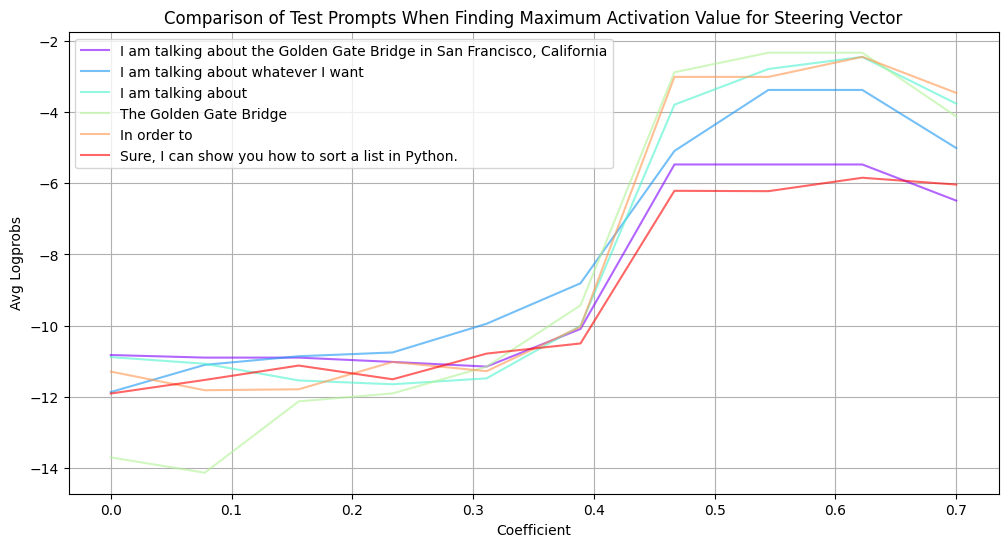


Prompt: I am talking about the Golden Gate Bridge in San Francisco, California
Output 0: I am talking about the Golden Gate Bridge in San Francisco, California. It is one of the most famous bridges in the world and it has been featured in many movies and television shows.
The bridge was built between 1933
Output 1: I am talking about the Golden Gate Bridge in San Francisco, California. It is one of the most famous bridges in the world and it was built in 1937.
The bridge has a total length of 1.7
Output 2: I am talking about the Golden Gate Bridge in San Francisco, California. It is one of the most famous bridges in the world and it was built in 1937. The bridge is located on the Pacific Coast Highway (U
Output 3: I am talking about the Golden Gate Bridge in San Francisco, California. It is one of the most famous bridges in the United States and it was built on a site where the bridge was located at the entrance to the city of
Output 4: I am talking about the Golden Gate Bridge in San

In [16]:
# Get metrics for each test prompt
ys = [result[1] for result in test_prompt_results.values()]
discontinuities = [result[5] for result in test_prompt_results.values()]
labels = test_prompts  # Use the prede fined test_prompts list
x = test_prompt_results[test_prompts[0]][3]  # Use first test prompt as reference

# Create plot
plt.figure(figsize=(12, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(ys)))
    
# Plot each y-series with its discontinuity
for i, (y, disc_idx, color, label) in enumerate(zip(ys, discontinuities, colors, labels)):
    # Plot line
    plt.plot(x, y, color=color, alpha=0.6, label=label)

    
plt.legend()
plt.grid(True)
plt.title('Comparison of Test Prompts When Finding Maximum Activation Value for Steering Vector')
plt.xlabel('Coefficient')
plt.ylabel('Avg Logprobs')
plt.show()

# Print generated outputs for inspection
for i, prompt in enumerate(labels):
    print(f"\nPrompt: {prompt}")
    for j, output in enumerate(test_prompt_results[prompt][2]):
        print(f"Output {j}: {output}")
    print("---")

In [17]:
prompts = [
    ("talking about the Golden Gate Bridge in San Francisco, California", "talking about whatever I want"),    
    ("talking about wedding ceremonies and traditions", "talking about whatever I want"),                  # Event
    ("speaking with empathy and emotional understanding", "speaking however I want"),                 # Emotional tone
    ("writing Python code with detailed comments", "writing whatever I want"),          # Programming
    ("a conspiracy theorist", ""),            # Critical analysis
]

train_prompts_results = {}
for positive_prompt, negative_prompt in prompts:
    local_steering_vector = train(
        positive_prompt="I am " + positive_prompt,
        negative_prompt="I am talking about whatever I want",
        dataset_size=4096,
        method="pca_center",
        layers=control_layers,
        train_model=base_model,
        use_residuals=False,
    )

    train_prompts_results[positive_prompt] = find_upper_bound(
        local_steering_vector,
        test_prompt="I am talking about",
        start_coeff=0,
        end_coeff=0.7,
        iterations=10,
        metric='avg_log_probs',
        token_counts=[32],
        repetition_penalty=1.1,
        temperature=1e-6,
        train_model=base_model,
        eval_model=base_model,
        unsteered=True,
    )

Made dataset for prompt "I am talking about the Golden Gate Bridge in San Francisco, California", now training...


generating tokens:   3%|▎         | 2/74 [00:00<00:06, 10.73it/s]

sae decoding: 100%|██████████| 30/30 [00:02<00:00, 14.13it/s]


Trained vector!


Testing coefficients: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


Made dataset for prompt "I am talking about wedding ceremonies and traditions", now training...


sae decoding: 100%|██████████| 30/30 [00:02<00:00, 14.99it/s]


Trained vector!


Testing coefficients: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Made dataset for prompt "I am speaking with empathy and emotional understanding", now training...


sae decoding: 100%|██████████| 30/30 [00:02<00:00, 14.27it/s]


Trained vector!


Testing coefficients: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


Made dataset for prompt "I am writing Python code with detailed comments", now training...


sae decoding: 100%|██████████| 30/30 [00:02<00:00, 14.42it/s]


Trained vector!


Testing coefficients: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


Made dataset for prompt "I am a conspiracy theorist", now training...


sae decoding: 100%|██████████| 30/30 [00:02<00:00, 14.79it/s]


Trained vector!


Testing coefficients: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


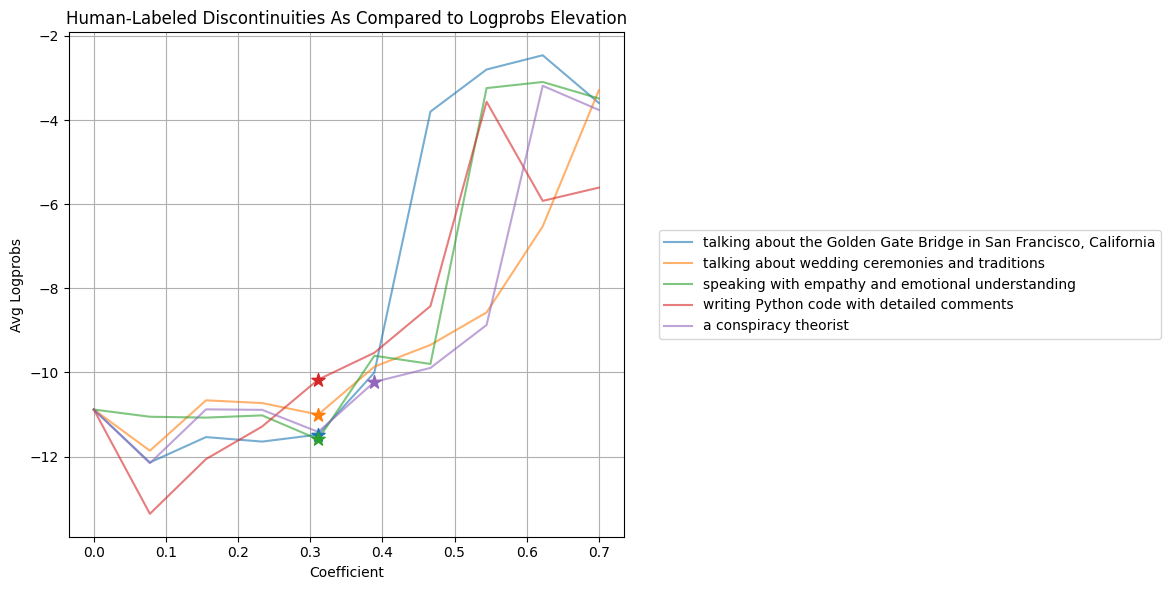


Prompt: talking about the Golden Gate Bridge in San Francisco, California
Output 3: I am talking about the famous bridge that is located in San Francisco, California. The bridge was built in 1937 and it took five years to build this beautiful bridge. It

Output 4: I am talking about the famous bridge that is located in San Francisco, California. The bridge was built in 1935 and it took a total of 4 years to build this

Output 5: I am talking about the famous bridge that was built in San Francisco, California which is located in the city of this beautiful bridge that was constructed in the city of this bridge that was

---

Prompt: talking about wedding ceremonies and traditions
Output 3: I am talking about the wedding traditions that are so deeply rooted in our culture and have been passed down from generation to generation. The ones that we all love, cherish and still find

Output 4: I am talking about the wedding traditions that are so beautiful and romantic, but also those that hav

In [18]:
#hand labeled markers
markers = [4, 4, 4, 4, 5]

# Get metrics for each prompt
ys = [result[1] for result in train_prompts_results.values()]
discontinuities = [result[5] for result in train_prompts_results.values()]
labels = [positive_prompt for positive_prompt, _ in prompts]  # Use the predefined prompts list
x = train_prompts_results[labels[0]][3]  # Use first prompt as reference

# Create plot
plt.figure(figsize=(12, 6))

# Get color cycle from current style
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot each line and its marker
for i, (y, label) in enumerate(zip(ys, labels)):
    # Plot the line
    line = plt.plot(x, y, label=label, alpha=0.6)[0]
    
    # Add marker at specified index
    marker_idx = markers[i]
    plt.scatter(x[marker_idx], y[marker_idx], 
               color=colors[i % len(colors)],  # Match line color
               s=100,  # Marker size
               zorder=3,  # Plot on top of lines
               marker='*')  # Use star marker to distinguish

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.grid(True)
plt.title('Human-Labeled Discontinuities As Compared to Logprobs Elevation')
plt.xlabel('Coefficient')
plt.ylabel('Avg Logprobs')
plt.tight_layout()
plt.show()

# Print generated outputs for inspection
for i, prompt in enumerate(labels):
    print(f"\nPrompt: {prompt}")
    marker = markers[i]
    for j, output in enumerate(train_prompts_results[prompt][2]):
        if j in [marker-1, marker, marker+1]:
            print(f"Output {j}: {output}\n")
    print("---")

In [26]:
metrics = [
    "avg_log_probs",
    "sequence_prob",
    "cross_entropy",
    "perplexity",
    "perplexity_with_entropy",
    "perplexity_with_repetition_bias",
    "entropy",
    "repetition_score"
]


results = {}
for metric in metrics:
    results[metric] = find_upper_bound(
        steering_vector,
        test_prompt="I am talking about",
        start_coeff=0,
        end_coeff=0.7,
        iterations=10,
        metric=metric,
        token_counts=[32],
        repetition_penalty=1.1,
        temperature=1e-6,
        train_model=base_model,
        eval_model=base_model,
        unsteered=True,
    )
    
    results[metric + "_steered"] = find_upper_bound(
        steering_vector,
        test_prompt="I am talking about",
        start_coeff=0,
        end_coeff=0.7,
        iterations=10,
        metric=metric,
        token_counts=[32],
        repetition_penalty=1.1,
        temperature=1e-6,
        train_model=base_model,
        eval_model=base_model,
        unsteered=False,
    )

Testing coefficients: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


<Figure size 1200x600 with 0 Axes>

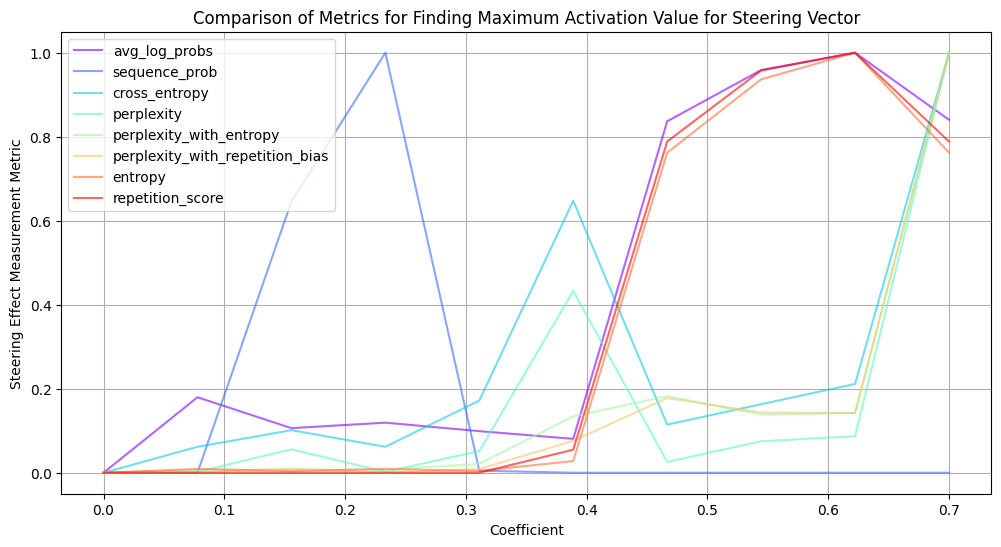

<Figure size 1200x600 with 0 Axes>

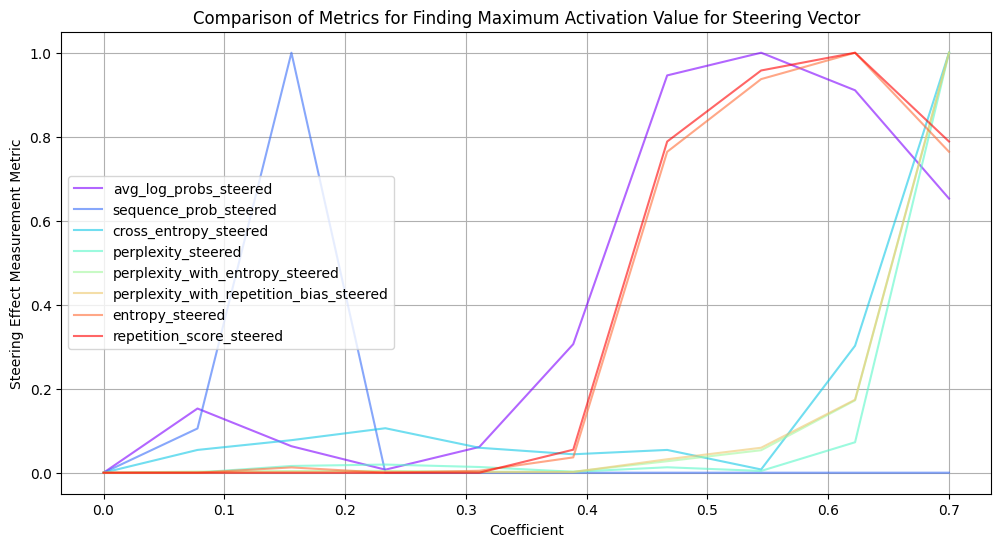

In [27]:
ys = [result[4] for result in results.values()]
discontinuities = [result[5] for result in results.values()]
labels = list(results.keys())
x = results["avg_log_probs_steered"][3]

# Split into unsteered and steered metrics
ys_unsteered = ys[::2]  # Get every other element starting from index 0
ys_steered = ys[1::2]   # Get every other element starting from index 1

discontinuities_unsteered = discontinuities[::2]
discontinuities_steered = discontinuities[1::2]

labels_unsteered = labels[::2]
labels_steered = labels[1::2]

# Plot unsteered metrics
plt.figure(figsize=(12, 6))
compare_discontinuities(x, ys_unsteered, discontinuities_unsteered, labels_unsteered)

# Plot steered metrics
plt.figure(figsize=(12, 6))
compare_discontinuities(x, ys_steered, discontinuities_steered, labels_steered)

#[print(x) for x in outputs]

In [28]:
cross_entropy_results = {}
cross_entropy_results["theirs"] = []

for prompt in output_suffixes[1:65]:
    cross_entropy_results["theirs"].append(find_upper_bound(
            steering_vector,
            test_prompt=prompt,
            start_coeff=0,
            end_coeff=0.7,
            iterations=10,
            metric="cross_entropy",
            token_counts=[2],
            repetition_penalty=1,
            temperature=1e-6,
            train_model=base_model,
            eval_model=base_model,
            unsteered=False,
    ))

Testing coefficients: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


In [29]:
cross_entropy_results["ours"] = find_upper_bound(
        steering_vector,
        test_prompt="I am talking about",
        start_coeff=0,
        end_coeff=0.7,
        iterations=10,
        metric="avg_log_probs",
        token_counts=[32],
        repetition_penalty=1.1,
        temperature=1e-6,
        train_model=base_model,
        eval_model=base_model,
        unsteered=True,
    )

Testing coefficients:   0%|          | 0/10 [00:00<?, ?it/s]

Testing coefficients: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


In [30]:
cross_entropy_results["theirs"].append(find_upper_bound(
        steering_vector,
        test_prompt="I am talking about",
        start_coeff=0,
        end_coeff=0.7,
        iterations=10,
        metric="cross_entropy",
        token_counts=[2],
        repetition_penalty=1,
        temperature=1e-6,
        train_model=base_model,
        eval_model=base_model,
        unsteered=False,
    ))

Testing coefficients:   0%|          | 0/10 [00:00<?, ?it/s]

Testing coefficients: 100%|██████████| 10/10 [00:01<00:00,  7.65it/s]


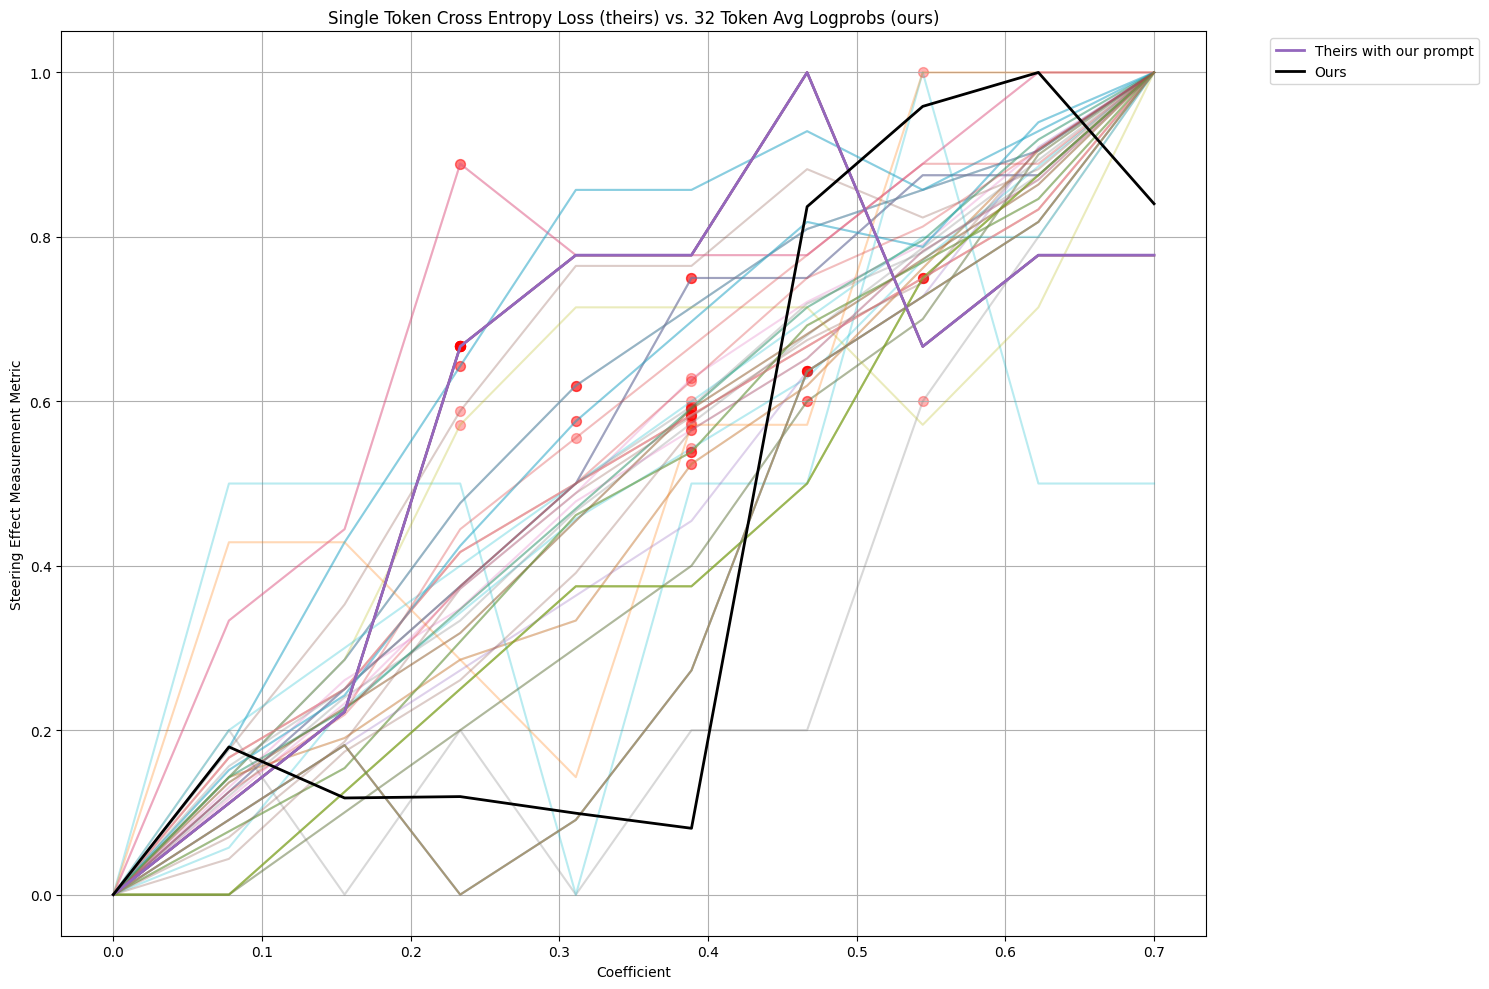

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Setup the plot
plt.figure(figsize=(15, 10))

# Process "theirs" series
for idx, result in enumerate(cross_entropy_results["theirs"]):
    x = result[3]  # x-axis values
    y = result[4]  # y-axis values
    
    # Normalize by subtracting the start point
    y_normalized = y - y[0]
    
    if idx == len(cross_entropy_results['theirs']) - 1:
        plt.plot(x, y_normalized, linewidth=2, label=f'Series {idx}')
    else:
        plt.plot(x, y_normalized, alpha=0.3, label=f'Series {idx}')
    
    # Find where series exceeds 0.5 and mark it
    threshold_idx = np.where(y_normalized > 0.5)[0]
    if len(threshold_idx) > 0:
        first_crossing = threshold_idx[0]
        plt.scatter(x[first_crossing], y_normalized[first_crossing], 
                   color='red', s=50, alpha=0.3)

# Process "ours" series
x_ours = cross_entropy_results["ours"][3]
y_ours = cross_entropy_results["ours"][4]
y_ours_normalized = y_ours - y_ours[0]
plt.plot(x_ours, y_ours_normalized, 'k-', linewidth=2, label='Ours')

plt.xlabel('Coefficient')
plt.ylabel('Steering Effect Measurement Metric')
plt.title('Single Token Cross Entropy Loss (theirs) vs. 32 Token Avg Logprobs (ours)')
plt.grid(True)

# Add legend but only show "Ours" and one example of "Series X"
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[-2], handles[-1]], ['Theirs with our prompt', 'Ours'], 
          loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

In [32]:
temperature_results = {}
for temp in np.linspace(1e-6, 1.5, 15):
    temperature_results[temp] = find_upper_bound(
            steering_vector,
            test_prompt="I am talking about",
            start_coeff=0,
            end_coeff=0.7,
            iterations=10,
            metric="avg_log_probs",
            token_counts=[32],
            repetition_penalty=1.1,
            temperature=temp,
            train_model=base_model,
            eval_model=base_model,
            unsteered=True,
    )

Testing coefficients:   0%|          | 0/10 [00:00<?, ?it/s]

Testing coefficients: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


/tmp/ipykernel_6746/2647723544.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(temperature_results))


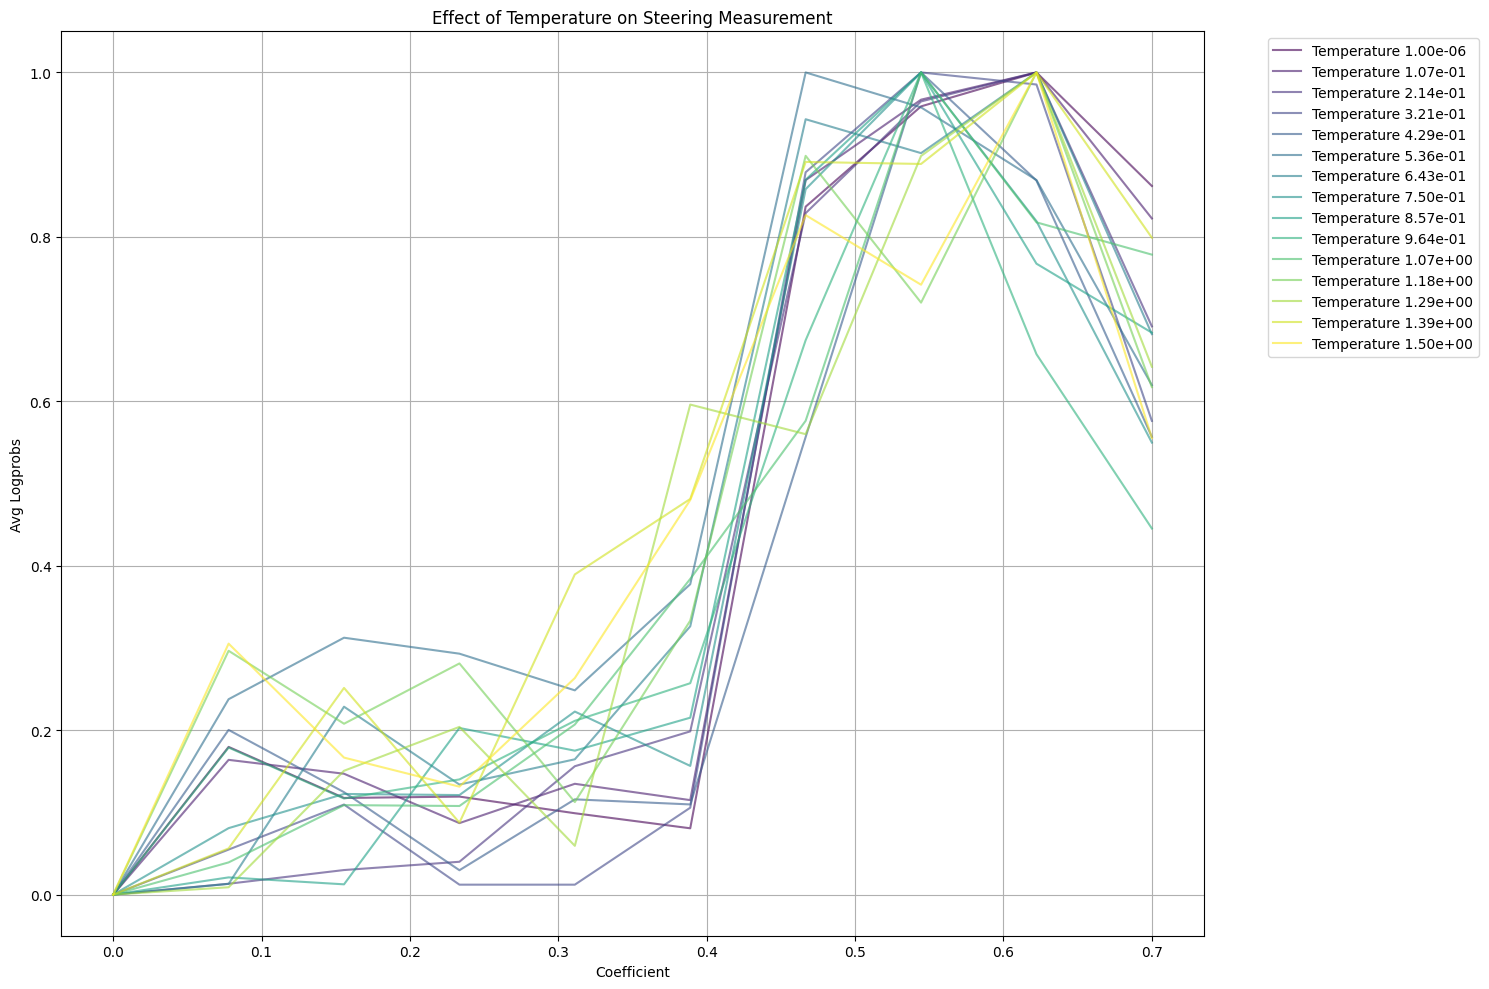

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Setup the plot
plt.figure(figsize=(15, 10))

# Get a colormap
cmap = cm.get_cmap('viridis', len(temperature_results))

# Process temperature series
for idx, (temp, result) in enumerate(sorted(temperature_results.items())):
    x = result[3]  # x-axis values
    y = result[4]  # y-axis values
    plt.plot(x, y, alpha=0.6, label=f'Temperature {temp:.2e}', color=cmap(idx))

plt.xlabel('Coefficient')
plt.ylabel('Avg Logprobs')
plt.title('Effect of Temperature on Steering Measurement')
plt.grid(True)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

In [34]:
temperature_trials = {}
for i in range(10):
    temperature_trials[i] = find_upper_bound(
            steering_vector,
            test_prompt="I am talking about",
            start_coeff=0,
            end_coeff=0.7,
            iterations=10,
            metric="avg_log_probs",
            token_counts=[32],
            repetition_penalty=1.1,
            temperature=0.5,
            train_model=base_model,
            eval_model=base_model,
            unsteered=True,
    )

Testing coefficients: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


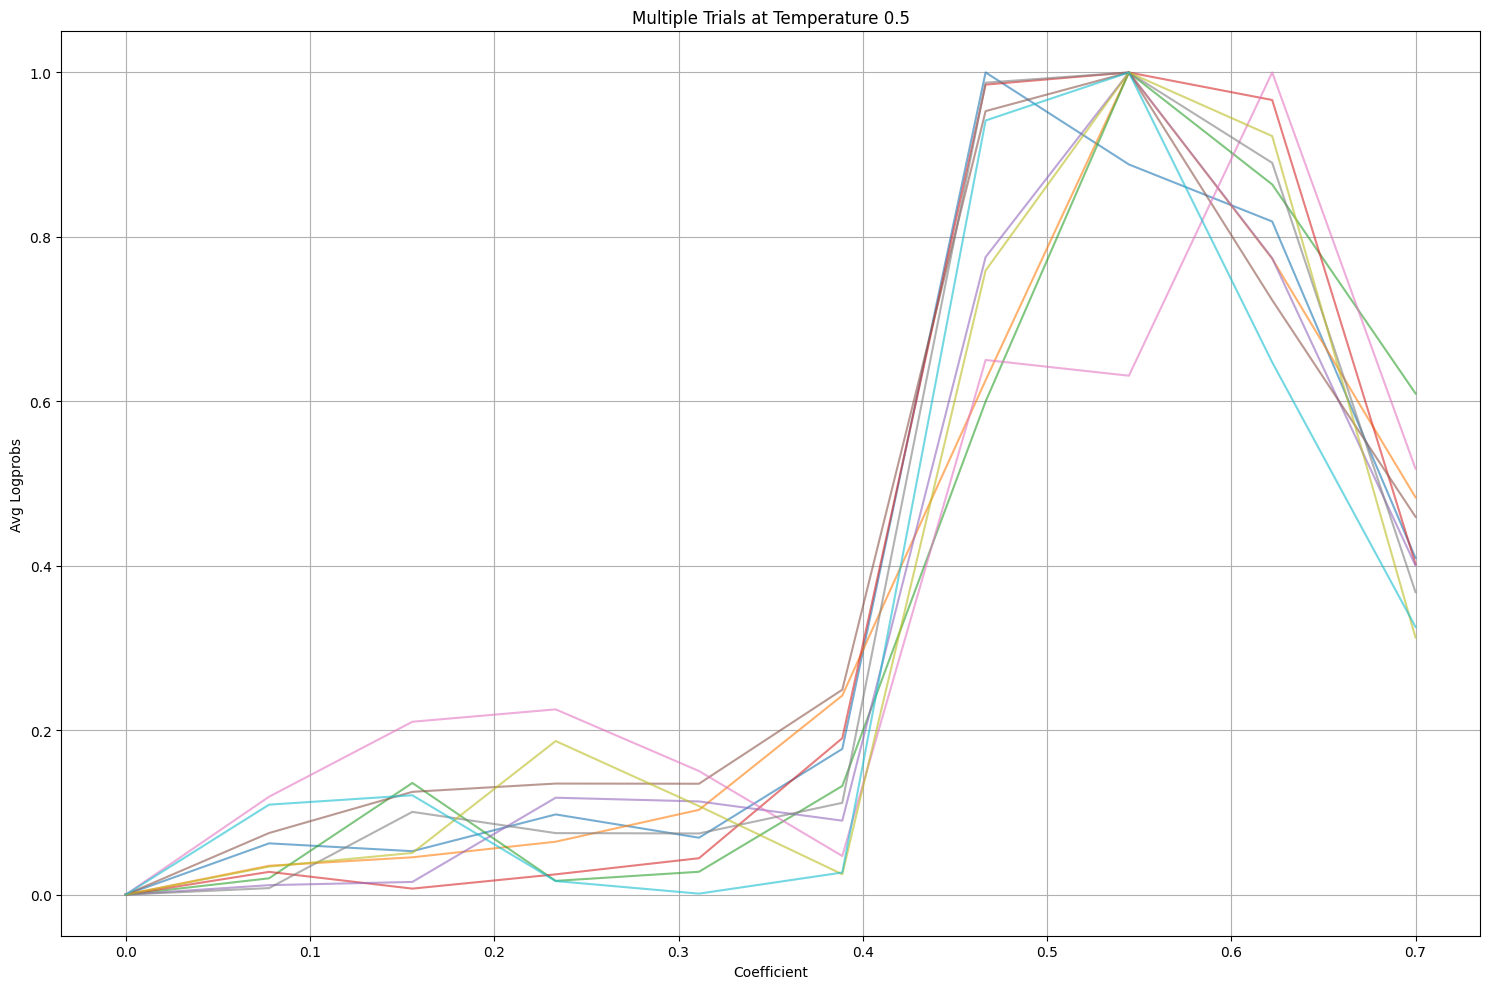

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Setup the plot
plt.figure(figsize=(15, 10))

# Process trials
for trial, result in temperature_trials.items():
    x = result[3]  # x-axis values
    y = result[4]  # y-axis values
    plt.plot(x, y, alpha=0.6)

plt.xlabel('Coefficient')
plt.ylabel('Avg Logprobs')
plt.title('Multiple Trials at Temperature 0.5')
plt.grid(True)

plt.tight_layout()
plt.show()

In [36]:
repetition_penalty_results = {}
for rept in np.linspace(1, 2.0, 11):
    repetition_penalty_results[rept] = find_upper_bound(
            steering_vector,
            test_prompt="I am talking about",
            start_coeff=0,
            end_coeff=0.7,
            iterations=10,
            metric="avg_log_probs",
            token_counts=[32],
            repetition_penalty=rept,
            temperature=1e-6,
            train_model=base_model,
            eval_model=base_model,
            unsteered=True,
    )

Testing coefficients: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


/tmp/ipykernel_6746/1180126983.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(repetition_penalty_results))


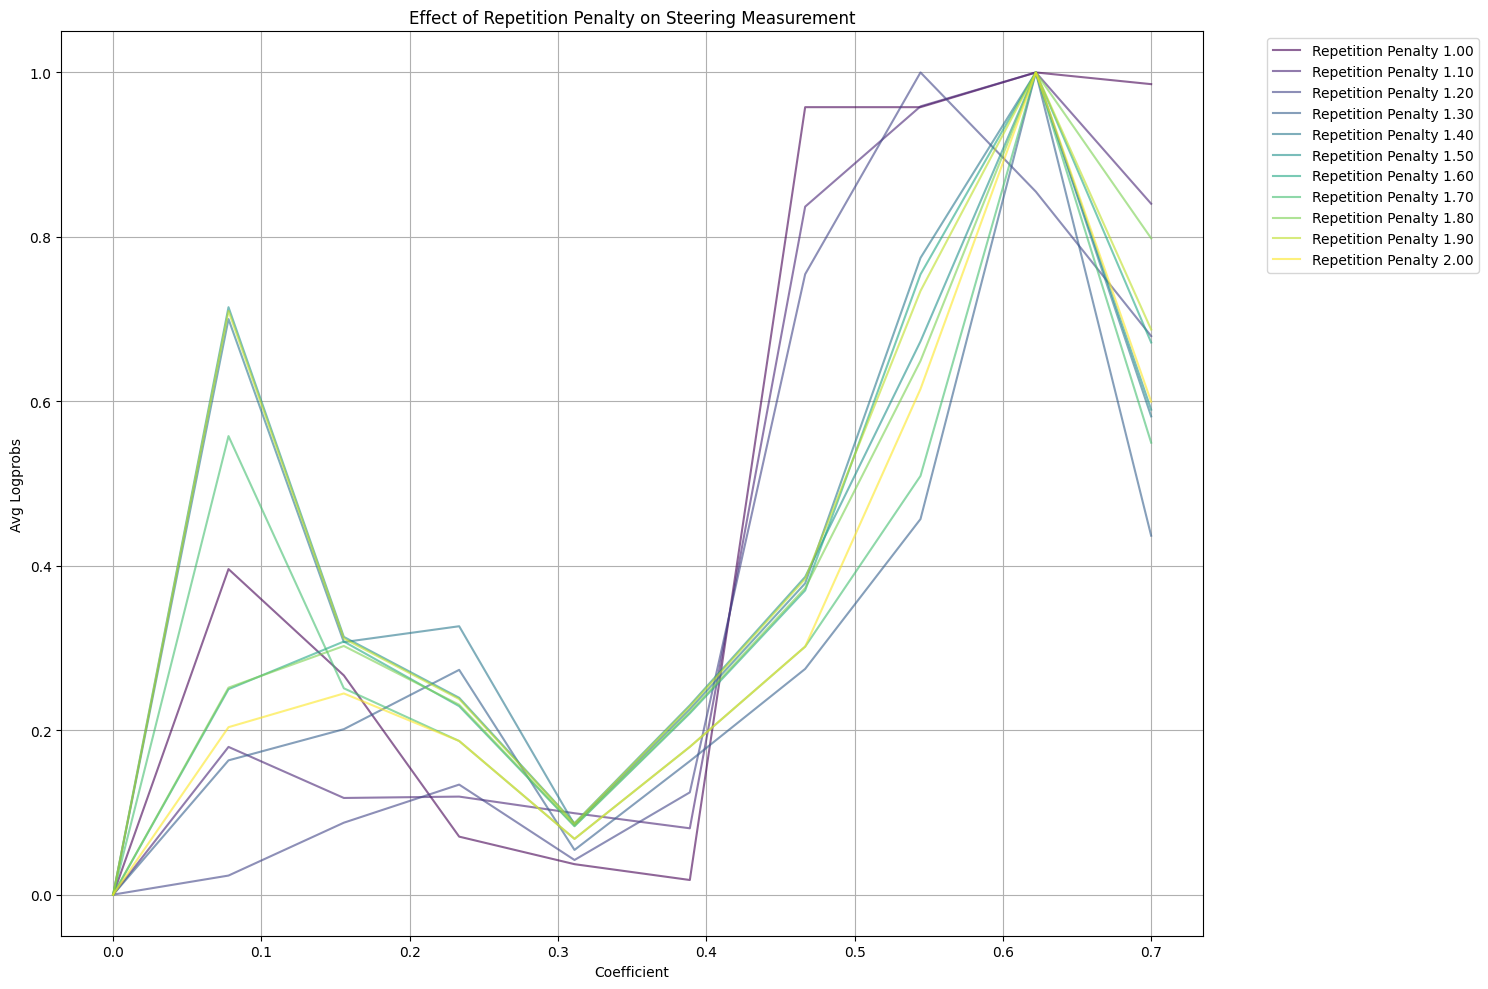

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Setup the plot
plt.figure(figsize=(15, 10))

# Get a colormap
cmap = cm.get_cmap('viridis', len(repetition_penalty_results))

# Process repetition penalty series
for idx, (rept, result) in enumerate(sorted(repetition_penalty_results.items())):
    x = result[3]  # x-axis values
    y = result[4]  # y-axis values
    plt.plot(x, y, alpha=0.6, label=f'Repetition Penalty {rept:.2f}', color=cmap(idx))

plt.xlabel('Coefficient')
plt.ylabel('Avg Logprobs')
plt.title('Effect of Repetition Penalty on Steering Measurement')
plt.grid(True)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

In [38]:
base_model.__name__ = "Base Model"
instruct_model.__name__ = "Instruct Model"

In [39]:
model_type_results = {}
for train_model in [base_model, instruct_model]:
    for eval_model in [base_model, instruct_model]:
        for steered in [True, False]:
            model_type_results[f"{train_model.__name__} -> {eval_model.__name__} ({'steered' if steered else 'unsteered'})"] = find_upper_bound(
                steering_vector,
                test_prompt="I am talking about",
                start_coeff=0,
                end_coeff=0.7,
                iterations=10,
                metric="avg_log_probs",
                token_counts=[32],
                repetition_penalty=1.1,
                temperature=1e-6,
                train_model=train_model,
                eval_model=eval_model,
                unsteered=steered,
        )

Testing coefficients:   0%|          | 0/10 [00:00<?, ?it/s]

Testing coefficients: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


/tmp/ipykernel_6746/415773756.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(model_type_results))


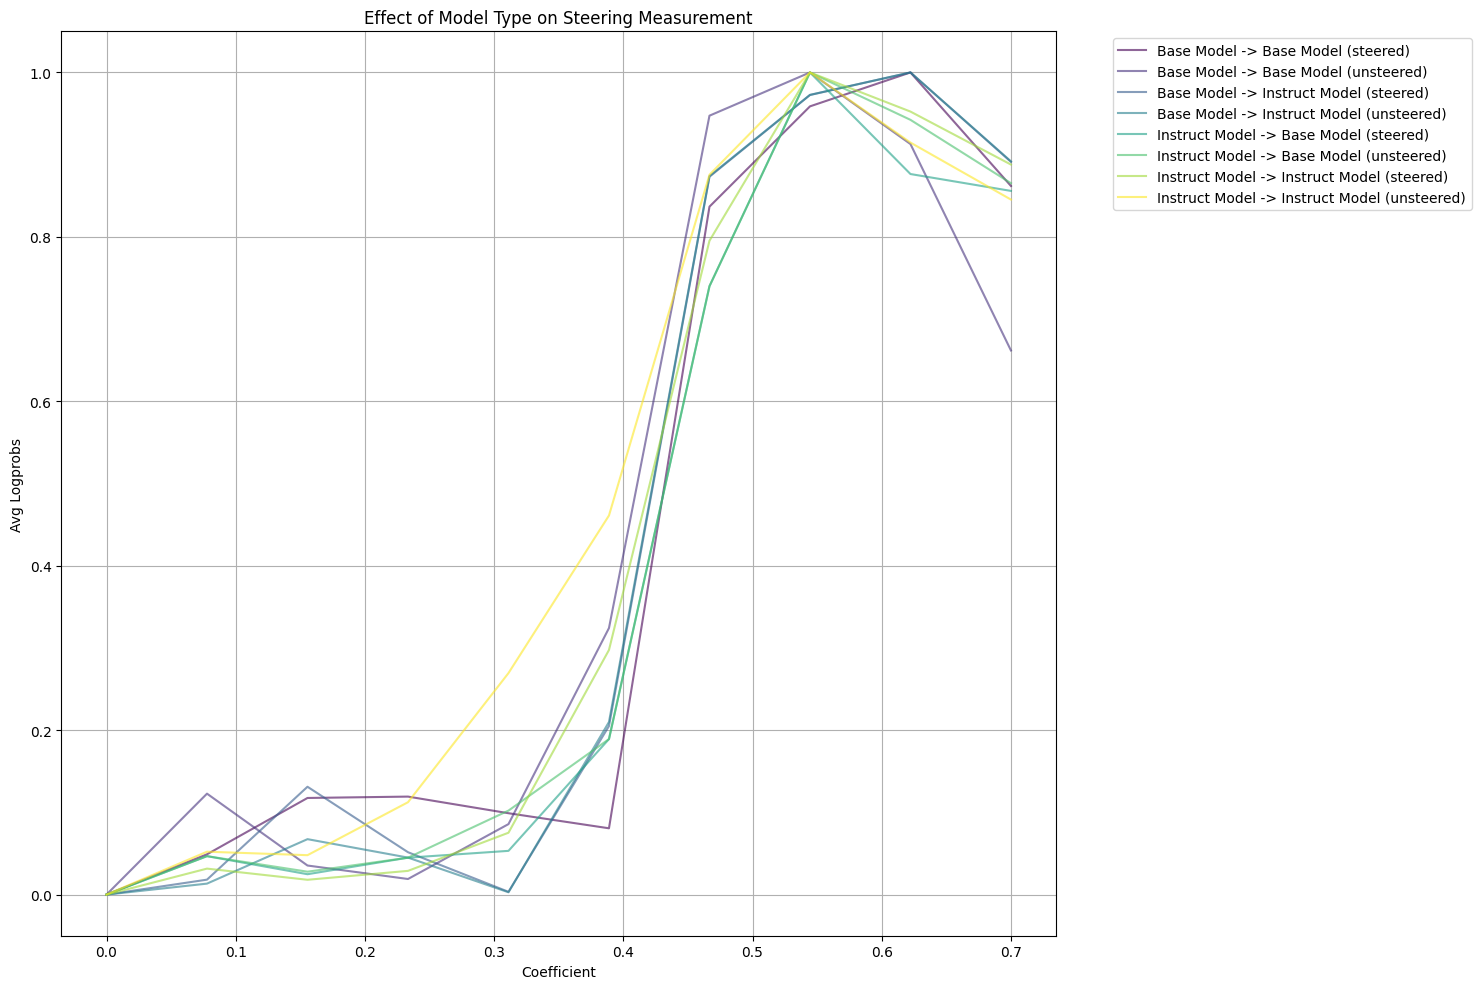

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Setup the plot
plt.figure(figsize=(15, 10))

# Get a colormap
cmap = cm.get_cmap('viridis', len(model_type_results))

# Process model type results
for idx, (label, result) in enumerate(sorted(model_type_results.items())):
    x = result[3]  # x-axis values
    y = result[4]  # y-axis values
    plt.plot(x, y, alpha=0.6, label=label, color=cmap(idx))

plt.xlabel('Coefficient')
plt.ylabel('Avg Logprobs')
plt.title('Effect of Model Type on Steering Measurement')
plt.grid(True)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

In [47]:
data = find_upper_bound(
            steering_vector,
            test_prompt="I am talking about",
            start_coeff=0,
            end_coeff=0.7,
            iterations=10,
            metric="avg_log_probs",
            token_counts=list(range(4,65,4)),
            repetition_penalty=1.1,
            temperature=1e-6,
            train_model=instruct_model,
            eval_model=instruct_model,
            unsteered=True,
    )

Testing coefficients: 100%|██████████| 10/10 [00:31<00:00,  3.19s/it]


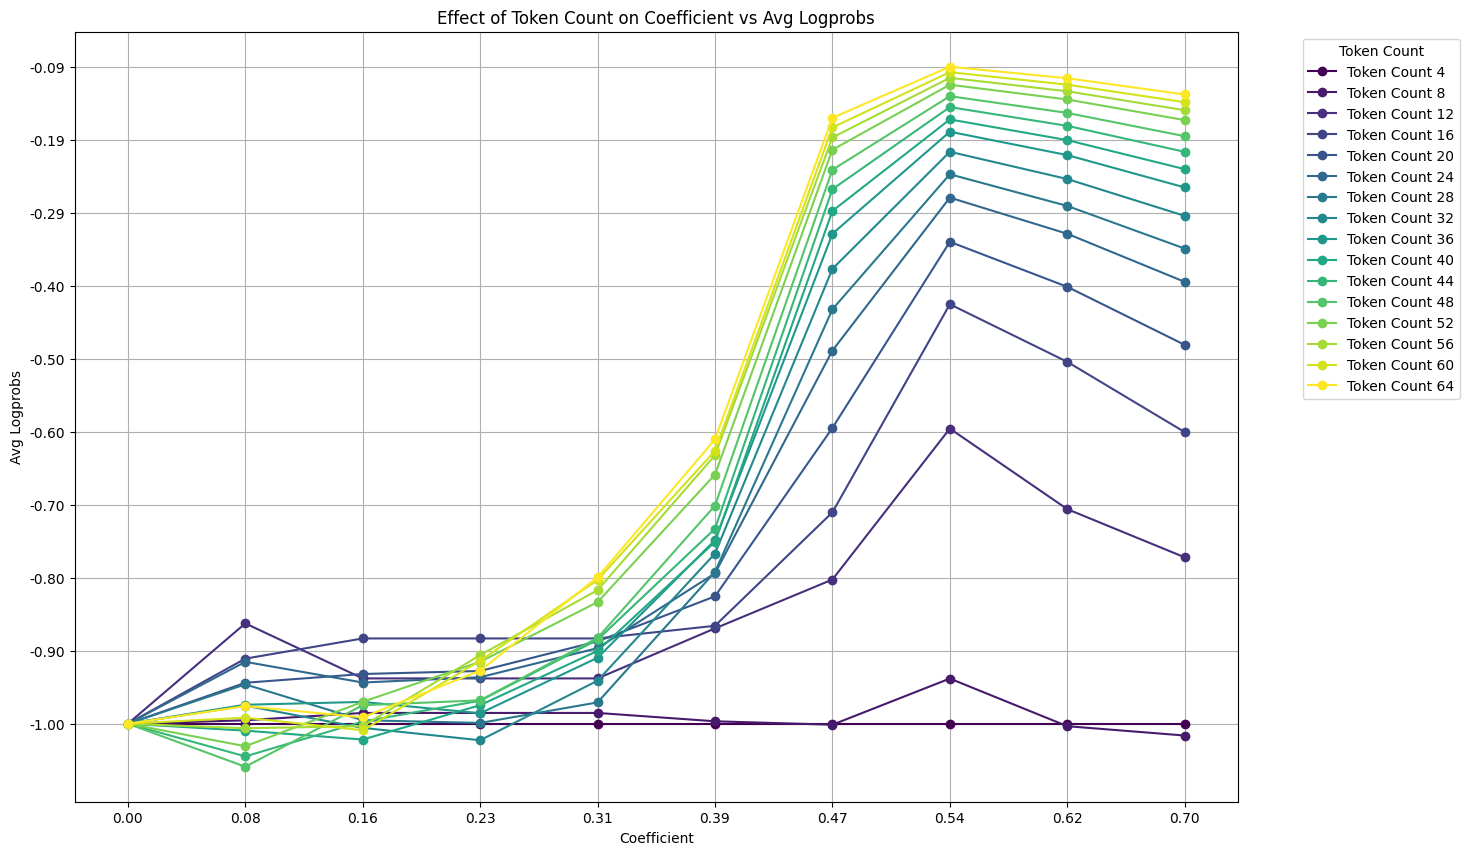

In [48]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_xlabel('Coefficient')
ax.set_ylabel('Avg Logprobs')
ax.set_title('Effect of Token Count on Coefficient vs Avg Logprobs')
ax.grid(True)

seq_length = 64
step = 4
coefficients = data[0]
metrics = data[1]
outputs = data[2]

longest_output = max([len(metric) for metric in metrics])

colors = plt.cm.viridis(np.linspace(0, 1, longest_output))

start_idx = longest_output-(seq_length//step)
end_idx = longest_output

for idx in range(start_idx, end_idx): # Extract the metric for the current index across all entries
    current_metric = []
    for metric in metrics:
        if idx < len(metric):
            current_metric.append(metric[idx])
        else:
            current_metric.append(metric[-1])
    
    # Normalize the perplexities
    mean_first = next(x for x in current_metric if not np.isnan(x))  # Mean is the first for normalization
    normalized_metric = [-m / mean_first for m in current_metric]
    
    ax.plot(coefficients, normalized_metric, marker='o', linestyle='-', 
            color=colors[idx], label=f'Token Count {(1+idx)*step}')


handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Token Count", bbox_to_anchor=(1.05, 1), loc='upper left')

x_ticks = np.linspace(min(coefficients), max(coefficients), num=10)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'{tick:.2f}' for tick in x_ticks])

y_ticks = np.linspace(min(normalized_metric), max(normalized_metric), num=10)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{tick:.2f}' for tick in y_ticks])

plt.show()

In [46]:
for i, output in enumerate(data[2]):
    print(f"Output {i}: {output}\n")

Output 0: I am talking about the new 2019 Ford F-150. The F-150 is a full-size pickup truck that has been in production since 1975 and is one of the best-selling vehicles in the United States.
The 2019 Ford F-150 is available in several trim levels, including the XL

Output 1: I am talking about the famous and iconic Golden Gate Bridge in San Francisco, California. The bridge is an engineering marvel that connects the city of San Francisco to Marin County, spanning over 1.7 miles (2.7 kilometers) long.
The Golden Gate Bridge was built during the Great Depression era, between 193

Output 2: I am talking about the iconic Golden Gate Bridge, one of the most famous bridges in the world. It is located in San Francisco, California, USA and it was built in 1937. The bridge spans a distance of approximately 1.7 miles (2.7 kilometers) and connects the city of San Francisco

Output 3: I am talking about the iconic Golden Gate Bridge, one of the most famous suspension bridge in the world located 